##Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
#Read in data
AllData=pd.read_csv('D:\GitHubRepos\StonySoilLysimeters\Calibration\CS650Calibration_CS650Callibration.dat', #specify file path for data to read in
                         parse_dates=True, #tell the function to parse date columns to datetime formats
                         dayfirst=True, #tell the function that the day is before the year in the data i.e format='%d/%m/%Y %H:%M'
                         skiprows = [0,2,3], #leave out rows 1, 3 and 4 which have redundant information
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

#Bring in index data
AllDataIndex=pd.read_csv('D:\GitHubRepos\StonySoilLysimeters\Calibration\CalibrationWater&TempIndex.csv',
                         index_col = 0)
#Apply indexes to data
AllDataTransposed = AllData.transpose()
AllDataIndexed = pd.concat([AllDataIndex,AllDataTransposed], axis=1)
AllDataIndexed.index.name='ColumnHeader'
AllDataIndexed.set_index(['Measurement','Treatment','Block','Sensor','Units','Summary','SDIport','SDIaddress'], 
                        append=False, inplace=True)
AllDataIndexed.sort(inplace=True)
Data=AllDataIndexed.transpose()
Data.index = Data.index.to_datetime()  ## for some reason the concat function changes the data type on the date indes so need to change it back

## Set time slice to graph

In [3]:
from datetime import timedelta #Import function needed for doing date deltas 
EndDate = Data.index.max()  #Set end of series as most recent date in file
EndDateString = EndDate.strftime("%Y-%m-%d")  #Turn this to a string
PlotDuration = 10
#Set the duration that you want to graph for
StartDate = EndDate - timedelta(weeks=PlotDuration)       #Set start date the specified duration before the end date 
StartDateString = StartDate.strftime("%Y-%m-%d")           #Turn that into a string
EndDate

Timestamp('2015-06-09 13:00:00')

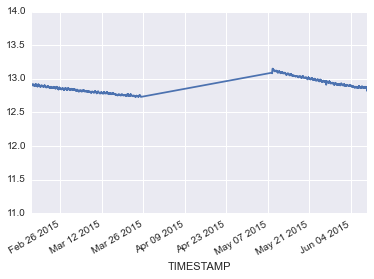

In [7]:
AllData['BattV_Avg'].plot(ylim=(11,14))


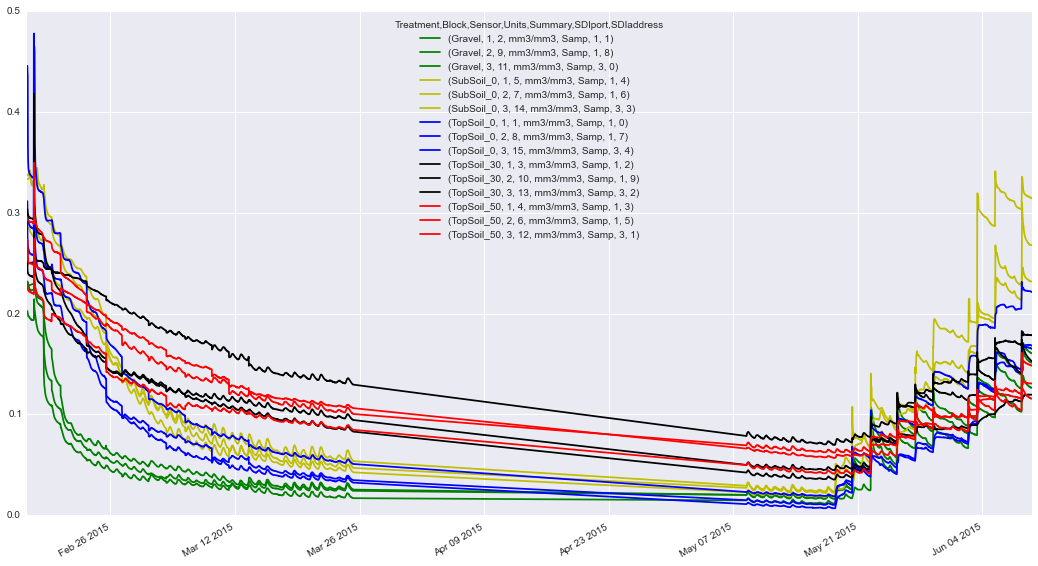

In [4]:
Data.VolumetricWaterContent.plot(figsize=(18,10),style=['g-','g-','g-','y-','y-','y-','b-','b-','b-','k-','k-','k-','r-','r-','r-'])

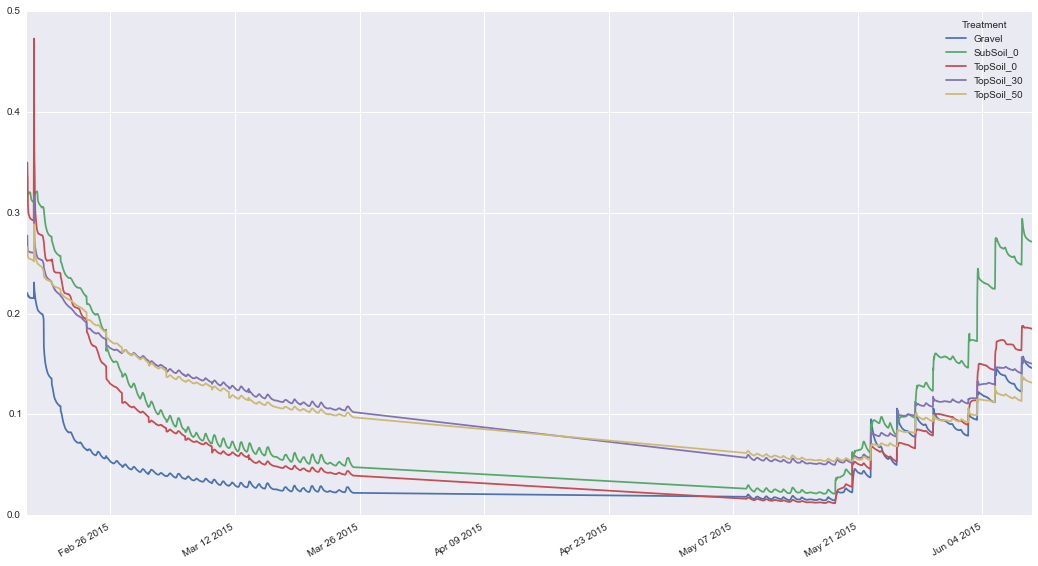

In [5]:
DataMeans =  Data.VolumetricWaterContent.groupby(level=['Treatment'],axis=1).mean()
DataMeans.plot(figsize=(18,10))

##Bring in gravometric data

In [6]:
GravometricData = pd.read_excel('D:\GitHubRepos\StonySoilLysimeters\Calibration\SoilWeightData.xlsx', sheetname='ForPython')
GravometricData.set_index(['Plot','Trt','TrtNo', 'Rep'], inplace=True)
GWCData=GravometricData.transpose()  #Gravometric water content
Dates =   GWCData.index.tolist()    #List dates when containers were weighed
TDRData = Data.VolumetricWaterContent.ix[Dates,:]   #Set up a dateframe with CS650 data for the same dates and times

DBD = pd.read_excel('D:\GitHubRepos\StonySoilLysimeters\Calibration\SoilWeightData.xlsx', sheetname='PythonBD')
DBD.set_index('Plot', inplace=True)
DBDData = DBD.transpose()  #Soil Dry Bulk Density Data frame

##Calculated volumetric water content from gravometric water content and soil dry bulk density

In [7]:
VWCData = pd.DataFrame(index = GWCData.index, columns = GWCData.columns)  #Set up empty dataframe with the same index and column structure as TDR data
for X in range (1,16): 
    Plot = 'P'+ np.str(X)
    VWCData.ix[:,Plot] = GWCData.ix[:,X-1].multiply(DBDData.ix['DBD',Plot])

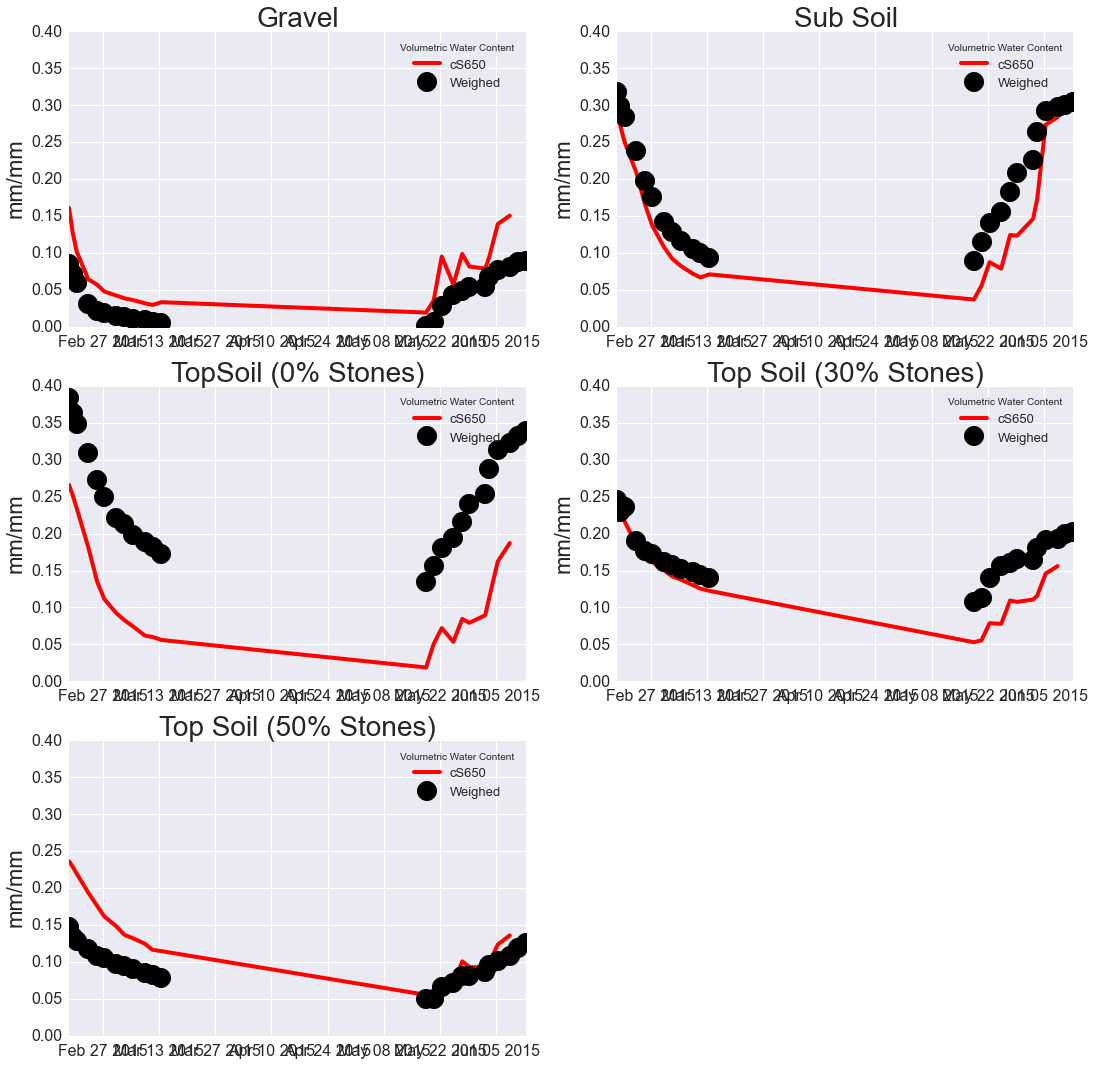

In [8]:
#calculate mean water contents from TDR
TDRMeans = TDRData.groupby(level =['Treatment'], axis=1).mean() 

#calculate mean gravometric water content
VWCMeans = VWCData.groupby(level=['Trt'],axis=1).mean()


Fig = plt.figure(figsize=(18, 18))

def MakePlot(Position, Horizon, HorizonLabel, Ymax):
        Fig.add_subplot(3,2,Position, color_cycle=['r','k'])
        plt.title(HorizonLabel, fontsize=28);
        plt.plot(TDRMeans.index, TDRMeans.ix[:,Horizon], '-', linewidth = 4, label='cS650' );
        plt.plot(VWCMeans.index, VWCMeans.ix[:,Horizon], 'o', markersize=20, label='Weighed' );
        plt.ylabel('mm/mm', fontsize=22);
        plt.tick_params(labelsize=16);
        plt.ylim(0,Ymax);
        plt.legend(loc=1, fontsize=13, title='Volumetric Water Content')
        return;

MakePlot(1,'Gravel','Gravel', 0.4) 
MakePlot(2, 'SubSoil_0', 'Sub Soil', 0.4)
MakePlot(3, 'TopSoil_0', 'TopSoil (0% Stones)', 0.4)
MakePlot(4, 'TopSoil_30','Top Soil (30% Stones)', 0.4)
MakePlot(5, 'TopSoil_50', 'Top Soil (50% Stones)', 0.4)

##Regress the data for each treatment to get callibrations

In [9]:
HorizonLables = pd.Series(VWCMeans.columns,name='Horizon')
#Add in two horizon labels for sub soil horizions that were not included in calibration
HorizonLables[5] = 'SubSoil_30'
HorizonLables[6] = 'SubSoil_50'
HorizonCoefficients = pd.DataFrame(0,index=HorizonLables,columns=['Slope','Intercept', 'LL', 'DUL'])

In [10]:
TDRMeans.Gravel[:'2015-04-01']

2015-02-18 13:30:00    0.161100
2015-02-19 11:00:00    0.128200
2015-02-20 11:30:00    0.101733
2015-02-23 09:00:00    0.064333
2015-02-25 14:00:00    0.057000
2015-02-27 08:30:00    0.047800
2015-03-02 08:00:00    0.042433
2015-03-04 08:00:00    0.038667
2015-03-06 11:00:00    0.036233
2015-03-09 10:30:00    0.031900
2015-03-11 09:00:00    0.029600
2015-03-13 14:30:00    0.033367
Name: Gravel, dtype: float64

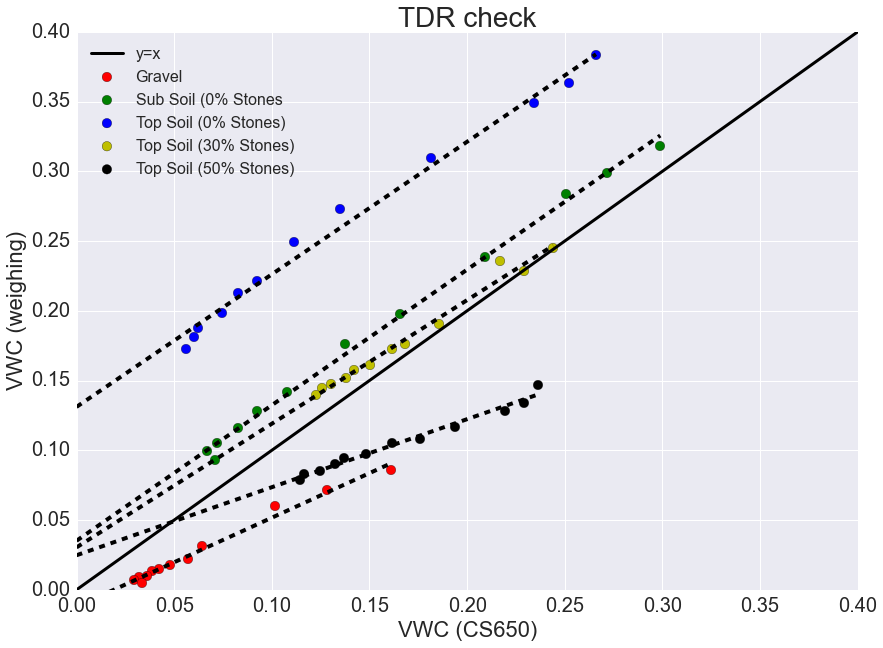

In [11]:
#Draw a graph with mean data
plt.figure(figsize=(14, 10));
plt.title('TDR check', fontsize=28);
plt.scatter(TDRMeans.Gravel[:'2015-04-01'], VWCMeans.Gravel[:'2015-04-01'], c='r', s=90, label='Gravel' );
plt.scatter(TDRMeans.SubSoil_0[:'2015-04-01'], VWCMeans.SubSoil_0[:'2015-04-01'], c='g', s=90, label='Sub Soil (0% Stones');
plt.scatter(TDRMeans.TopSoil_0[:'2015-04-01'], VWCMeans.TopSoil_0[:'2015-04-01'], c='b', s=90, label='Top Soil (0% Stones)');
plt.scatter(TDRMeans.TopSoil_30[:'2015-04-01'], VWCMeans.TopSoil_30[:'2015-04-01'], c='y', s=90, label='Top Soil (30% Stones)');
plt.scatter(TDRMeans.TopSoil_50[:'2015-04-01'], VWCMeans.TopSoil_50[:'2015-04-01'], c='k', s=90, label='Top Soil (50% Stones)');
plt.plot([0,0.5], [0,0.5], 'k-', linewidth = 3, label = 'y=x')
plt.ylim(0,0.4);
plt.xlim(0,0.4);
plt.xlabel('VWC (CS650)', fontsize=22);
plt.ylabel('VWC (weighing)', fontsize=22);
plt.tick_params(labelsize=20)

#Fit regressions to each treatment for the dry down data
for X in range(0,5):
    Treatment = HorizonLables[X]
    ModTemp = sm.regression.linear_model.OLS(VWCMeans.ix[:'2015-04-01',Treatment],  # Y variable
                                        sm.add_constant(TDRMeans.ix[:'2015-04-01',Treatment]), # X variable
                                        missing='drop',                                     # ignor and data where one value is missing
                                        hasconst=False) 
    RegCalib = ModTemp.fit();  # fit models parameters

#Add regressions onto graph
    xmin = 0#TDRMeans.ix[:'2015-04-01',Treatment].min()
    xmax = TDRMeans.ix[:'2015-04-01',Treatment].max()
    Regres = RegCalib
    VWC_x = [xmin,xmax];
    VWC_y_fits = [Regres.params.const + xmin * Regres.params.get_value(Treatment), Regres.params.const + xmax * Regres.params.get_value(Treatment)];
    plt.plot(VWC_x, VWC_y_fits, 'k--', lw=4);
    
#Assign coeffients to dataframe
    HorizonCoefficients.ix[Treatment,'Slope'] = Regres.params.get_value(Treatment)
    HorizonCoefficients.ix[Treatment,'Intercept'] = Regres.params.const
    
#Add wet up data onto graph
#plt.scatter(TDRMeans.Gravel['2015-04-01':], VWCMeans.Gravel['2015-04-01':], c='r', s=90, label='Wetup Gravel', marker='*');
#plt.scatter(TDRMeans.SubSoil_0['2015-04-01':], VWCMeans.SubSoil_0['2015-04-01':], c='g', s=90, label='Wetup Sub Soil (0% Stones)', marker='*');
#plt.scatter(TDRMeans.TopSoil_0['2015-04-01':], VWCMeans.TopSoil_0['2015-04-01':], c='b', s=90, label='Wetup Top Soil (0% Stones)', marker='*');
#plt.scatter(TDRMeans.TopSoil_30['2015-04-01':], VWCMeans.TopSoil_30['2015-04-01':], c='y', s=90, label='Wetup Top Soil (30% Stones)', marker='*');
#plt.scatter(TDRMeans.TopSoil_50['2015-04-01':], VWCMeans.TopSoil_50['2015-04-01':], c='k', s=90, label='Wetup Top Soil (50% Stones)', marker='*');

plt.legend(loc=0, fontsize=16)


In [12]:
VWCData.index = VWCData.index.to_datetime() 

In [13]:
VWCDataUpper = VWCData[:'2015-04-01'].max(axis=0)
VWCDataLower = VWCData[:'2015-04-01'].min(axis=0)
PAWC = VWCDataUpper - VWCDataLower
PAWCLiters = PAWC * 35 # crates are 35 liters
RewettingVolumes = PAWCLiters/5
RewettingVolumes.groupby(level='Trt').mean()

Trt
Gravel        0.566727
SubSoil_0     1.578643
TopSoil_0     1.471917
TopSoil_30    0.757243
TopSoil_50    0.476932
dtype: float64

In [14]:
HorizonLL = VWCDataLower.groupby(level='Trt').mean()

In [23]:
#Estimate slope for sub soil horizions in relation to the stone effect from top soil horizons
HorizonCoefficients.ix['SubSoil_30','Slope'] = 0.75#HorizonCoefficients.ix['SubSoil_0','Slope'] + \
#(HorizonCoefficients.ix['TopSoil_30','Slope']-HorizonCoefficients.ix['TopSoil_0','Slope'])
HorizonCoefficients.ix['SubSoil_50','Slope'] = 0.55#HorizonCoefficients.ix['SubSoil_0','Slope'] + \
#(HorizonCoefficients.ix['TopSoil_50','Slope']-HorizonCoefficients.ix['TopSoil_0','Slope'])
HorizonCoefficients.ix['SubSoil_30','Intercept'] = 0#HorizonCoefficients.ix['SubSoil_0','Intercept'] + \
#(HorizonCoefficients.ix['TopSoil_30','Intercept']-HorizonCoefficients.ix['TopSoil_0','Intercept'])
HorizonCoefficients.ix['SubSoil_50','Intercept'] = 0#HorizonCoefficients.ix['SubSoil_0','Intercept'] + \
#(HorizonCoefficients.ix['TopSoil_50','Intercept']-HorizonCoefficients.ix['TopSoil_0','Intercept'])

#Set Lower limit values for each horizon type
HorizonCoefficients.LL = HorizonLL  #use lowest measured values for observed horizions
HorizonCoefficients.ix['SubSoil_30','LL'] = HorizonCoefficients.ix['SubSoil_0','LL'] * 0.7  
#Estamate for stony sub soils based on stone free value and stone volume
HorizonCoefficients.ix['SubSoil_50','LL'] = HorizonCoefficients.ix['SubSoil_0','LL'] * 0.5

#Set drained upper limits for each horizion type
HorizonCoefficients.ix['Gravel','DUL'] = 0.12
SubSoilDUL = 0.32
TopSoilDUL = 0.35

HorizonCoefficients.ix['SubSoil_0','DUL'] = SubSoilDUL
HorizonCoefficients.ix['TopSoil_0','DUL'] = TopSoilDUL 
HorizonCoefficients.ix['SubSoil_30','DUL'] = SubSoilDUL * 0.7
HorizonCoefficients.ix['TopSoil_30','DUL'] = TopSoilDUL * 0.7
HorizonCoefficients.ix['SubSoil_50','DUL'] = SubSoilDUL * 0.5
HorizonCoefficients.ix['TopSoil_50','DUL'] = TopSoilDUL * 0.5


In [24]:
for Hor in HorizonCoefficients.index:
    HorizonCoefficients.ix[Hor,'SWC25'] = HorizonCoefficients.ix[Hor,'Intercept'] + \
    HorizonCoefficients.ix[Hor,'Slope'] * 0.25

In [25]:
HorizonCoefficients

,Slope,Intercept,LL,DUL,SWC25
Horizon,,,,,
Gravel,0.638859,-0.012200,0.004688,0.120,0.147515
SubSoil_0,0.971923,0.035146,0.092807,0.320,0.278127
TopSoil_0,0.950379,0.131111,0.172804,0.350,0.368705
TopSoil_30,0.886315,0.030407,0.139319,0.245,0.251986
TopSoil_50,0.487783,0.024764,0.078916,0.175,0.146709
SubSoil_30,0.750000,0.000000,0.064965,0.224,0.187500
SubSoil_50,0.550000,0.000000,0.046403,0.160,0.137500


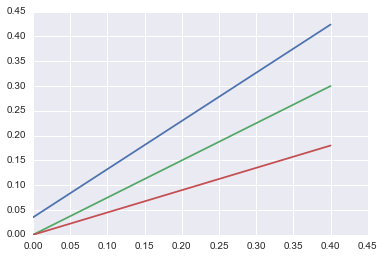

In [59]:
Hors = ['SubSoil_0','SubSoil_30','SubSoil_50']
x=[0,0.4]
for Hor in Hors:
    y=[]
    y.append(HorizonCoefficients.ix[Hor,'Intercept'] + HorizonCoefficients.ix[Hor,'Slope'] * x[0]) 
    y.append(HorizonCoefficients.ix[Hor,'Intercept'] + HorizonCoefficients.ix[Hor,'Slope'] * x[1]) 
    plt.plot(x,y)

In [26]:
HorizonCoefficients.to_pickle('D:\GitHubRepos\StonySoilLysimeters\Calibration\CS650Calibration.pkl')

In [ ]:
#!gist -p -d "Setting up CSC650 calibration for Export" CS650Calibration.ipynb

In [ ]:
!gist -u https://gist.github.com/2b9d3cd05aefe707c181 CS650Calibration.ipynb